d:\anaconda\envs\quant\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\quant\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\quant\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\quant\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\quant\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.c

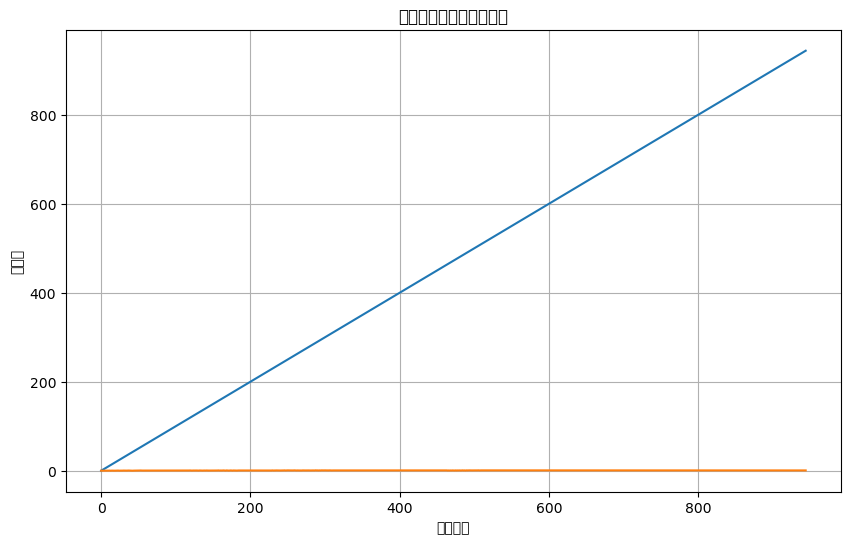

(945, 3)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv(r'c:\Users\hxq11\Downloads\fulltry8.csv')

# 创建图像
plt.figure(figsize=(10,6))
plt.plot(data.iloc[:,1:3])  # 只绘制第2、3列数据
plt.title('模型训练准确率变化趋势')
plt.xlabel('训练步数')
plt.ylabel('准确率')
plt.grid(True)
plt.show()
data.shape
